# Machine Learning: Loan Default Predictor

## **Introduction:**

In this project I will be using a loan data set to make predictions on whether a loan (with certain characteristics) will default.

I will train the following models:

- Logistic Regression: Baseline  model for performance comparison.
- Random Forest: Ensemble method known for its ability to handle complex data structures.
- Gradient Boosting Machine (GBM) OR XGBoost: Advanced ensemble tknown for their predictive ability.
- Neural Network (MLP): A method that uses interconnected nodes that process information and each different node connection has a different weight to resemble its importance to for the model. We will be using a specific class of a NN called MPL that has 3 layers and will find non-linear relationships
- StackingClassifier: A combined model that uses other models and creates one. Additionaly, the model auto tunes for you. Simple and easy way to make a machine learning model.



## Load Libraries:

In [110]:
#!pip uninstall scikit-learn --yes
#!pip install scikit-learn==1.2.2

In [111]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules
from sklearn.model_selection import train_test_split    #- partition train/test split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier        #- multi-layer perceptron
from sklearn.preprocessing import LabelBinarizer


# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# -- need this to render charts in notebook --
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint


## Load Data:

In [112]:
loan = pd.read_csv('https://raw.githubusercontent.com/MikeVej/ML_LoanDefaults/main/Loan%20Data/loan_train.csv')
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.00000,1296599.00000,5000.00000,5000.00000,4975.00000,36 months,10.65%,162.87000,B,B2,...,NaN,Sep-2016,0.00000,1.00000,INDIVIDUAL,0.00000,0.00000,0.00000,0.00000,0.00000
1,1077430.00000,1314167.00000,2500.00000,2500.00000,2500.00000,60 months,15.27%,59.83000,C,C4,...,NaN,Sep-2016,0.00000,1.00000,INDIVIDUAL,0.00000,0.00000,0.00000,0.00000,0.00000
2,1076863.00000,1277178.00000,10000.00000,10000.00000,10000.00000,36 months,13.49%,339.31000,C,C1,...,NaN,Apr-2016,0.00000,1.00000,INDIVIDUAL,0.00000,0.00000,0.00000,0.00000,0.00000
3,1069639.00000,1304742.00000,7000.00000,7000.00000,7000.00000,60 months,15.96%,170.08000,C,C5,...,NaN,Sep-2016,0.00000,1.00000,INDIVIDUAL,0.00000,0.00000,0.00000,0.00000,0.00000
4,1072053.00000,1288686.00000,3000.00000,3000.00000,3000.00000,36 months,18.64%,109.43000,E,E1,...,NaN,Dec-2014,0.00000,1.00000,INDIVIDUAL,0.00000,0.00000,0.00000,0.00000,0.00000


### Columns in data

In [113]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [114]:
loan.loan_status.value_counts(normalize=True)

current   0.84965
default   0.15035
Name: loan_status, dtype: float64

In [115]:
loan_status_types = loan['loan_status'].unique()
print(loan_status_types)

['current' 'default']


## Exporatory Analysis

### Zips where default is > 30

In [116]:
# Zip codes where default counts is > 30
zip_df = loan.pivot_table(index='zip_code', columns='loan_status', aggfunc='size', fill_value=0)

df_postal_count = loan.groupby(['zip_code'])['loan_status'].count().to_frame()

postal_list = list(df_postal_count[df_postal_count['loan_status']>=30].index)

###  Graph: Top defaults by zip code

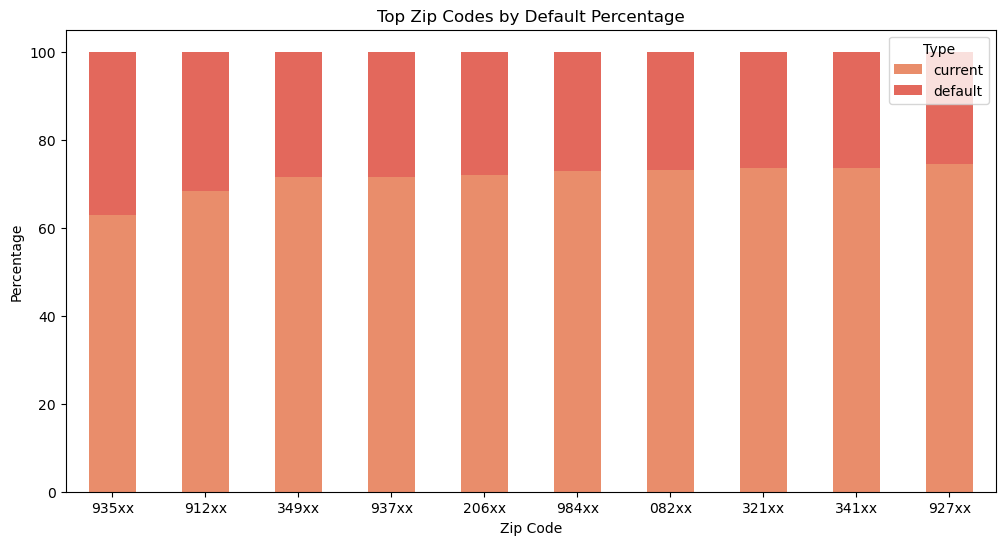

In [117]:
zip_df.reset_index()
# Calculate percentages
pivot_percentage = zip_df[['current', 'default']].div(zip_df[['current', 'default']].sum(axis=1), axis=0) * 100
pivot_percentage = pivot_percentage.sort_values('default',ascending=False)
df_viz = pivot_percentage[pivot_percentage.index.isin(postal_list)]
sns.set_palette("flare")
df_viz.head(10).plot(kind='bar', stacked=True, grid=False, figsize=(12, 6))
plt.title('Top Zip Codes by Default Percentage')
plt.xlabel('Zip Code')
plt.ylabel('Percentage')
plt.legend(title='Type')
plt.xticks(rotation=0)
plt.show()

### Graph: Top Defaults by emplyment length

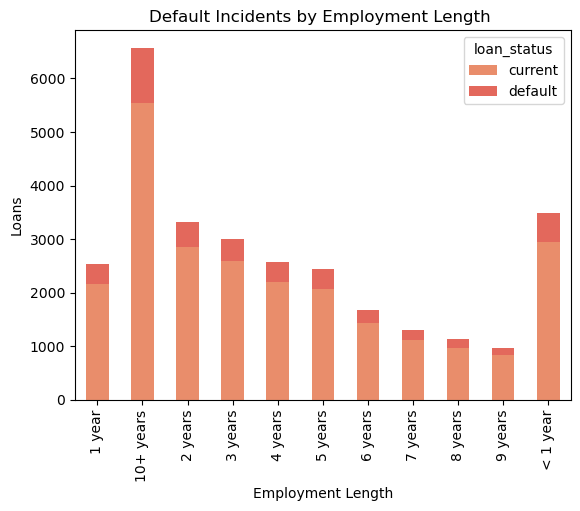

In [118]:
#Plot Fraud Incidents by years working
df_pivot = loan.pivot_table(index='emp_length', columns='loan_status', aggfunc='size', fill_value=0)
df_pivot.plot.bar(stacked=True, grid=False)
plt.xlabel('Employment Length')
plt.ylabel('Loans')
plt.title('Default Incidents by Employment Length ')
plt.show()

### Graph: Top Defaults by employment title

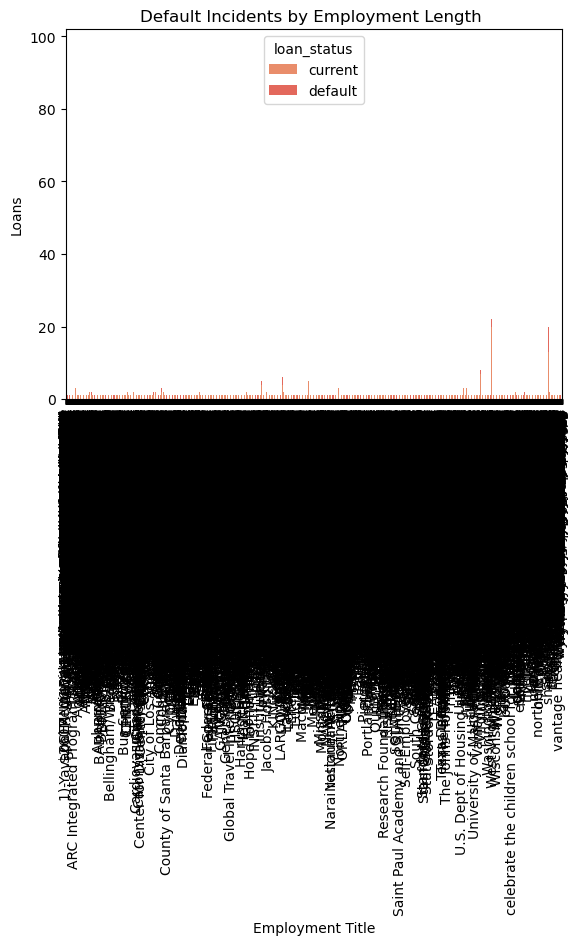

In [119]:
#Plot Fraud Incidents by years working
df_pivot = loan.pivot_table(index='emp_title', columns='loan_status', aggfunc='size', fill_value=0)
df_pivot.plot.bar(stacked=True, grid=False)
plt.xlabel('Employment Title')
plt.ylabel('Loans')
plt.title('Default Incidents by Employment Length ')
plt.show()

### Graph: Numeric Variable Distributions

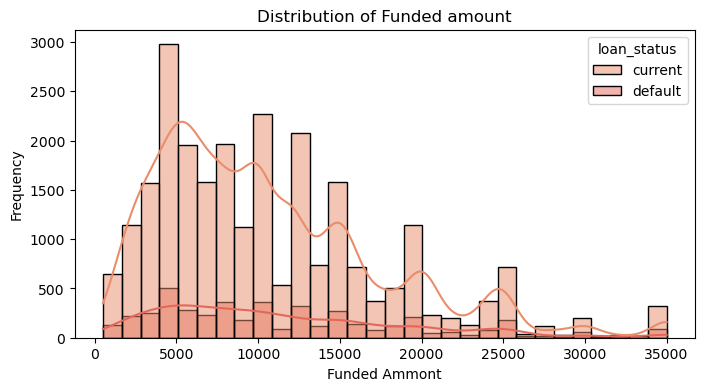

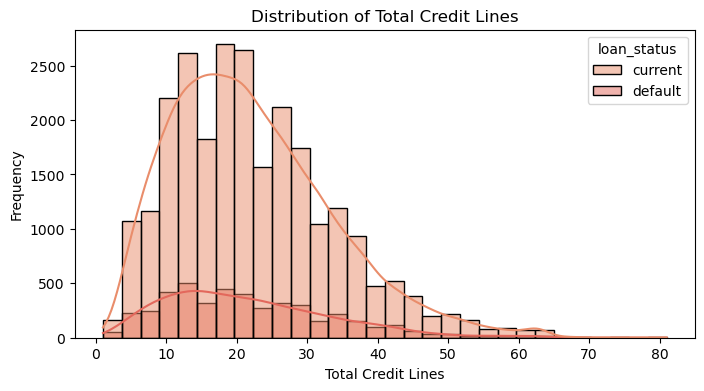

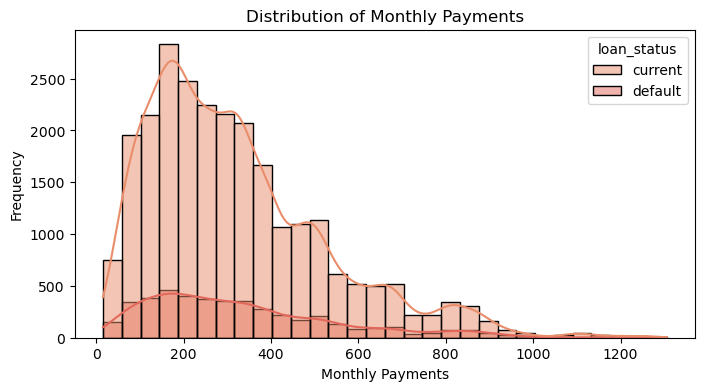

In [120]:
plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='funded_amnt', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Funded amount')
plt.xlabel('Funded Ammont')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='total_acc', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Total Credit Lines')
plt.xlabel('Total Credit Lines')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='installment', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Monthly Payments')
plt.xlabel('Monthly Payments')
plt.ylabel('Frequency')
plt.show()
    

## Data Prep:

### Identify features (Categorical/Numerical):

#### Describe Data:

##### Use this code to find feature warnings for feature selection (Un-comment to run tuning)

In [121]:
def df_profile(df, target):

    df = loan.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)

    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"#
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

dfp = df_profile(loan, 'loan_status')

dfp

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,id,float64,29774,29774,663006.18452,54734.00000,1077501.00000,3,29774,0.00010,0.99990,NUMERIC,"EXCLUDE, GT 90% UNIQUE"
1,fico_range_low,float64,29774,43,713.05317,610.00000,825.00000,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
2,fico_range_high,float64,29774,43,717.05317,614.00000,829.00000,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
3,inq_last_6mths,float64,29754,27,1.08409,0.00000,33.00000,23,29754,0.00077,0.00091,NUMERIC,NO WARNING
4,mths_since_last_delinq,float64,10870,90,34.71582,0.00000,120.00000,18907,10870,0.63495,0.00302,NUMERIC,"EXCLUDE, GT 50% MISSING"
5,mths_since_last_record,float64,2569,107,59.22538,0.00000,129.00000,27208,2569,0.91373,0.00359,NUMERIC,"EXCLUDE, GT 50% MISSING"
6,open_acc,float64,29754,44,9.33901,1.00000,47.00000,23,29754,0.00077,0.00148,NUMERIC,NO WARNING
7,pub_rec,float64,29754,6,0.05855,0.00000,5.00000,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
8,revol_bal,float64,29774,18399,14310.00064,0.00000,1207359.00000,3,29774,0.00010,0.61789,NUMERIC,NO WARNING
9,pub_rec_bankruptcies,float64,28811,3,0.04533,0.00000,2.00000,966,28811,0.03244,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"


#### Unique Values in different columns:

In [122]:
loan_status_types = loan['emp_title'].unique()
print(loan_status_types)


[nan 'Ryder' 'AIR RESOURCES BOARD' ... 'Town of Plainville' 'Tanks Tavern'
 'Halping hands company inc.']


In [123]:
loan['issue_d'].value_counts()

Dec-2011    1581
Nov-2011    1568
Oct-2011    1467
Sep-2011    1453
Aug-2011    1359
Jul-2011    1279
Jun-2011    1240
May-2011    1181
Apr-2011    1081
Mar-2011    1001
Dec-2010     957
Jan-2011     941
Feb-2011     916
Oct-2010     857
Jul-2010     856
Nov-2010     847
Sep-2010     834
Aug-2010     825
Jun-2010     749
May-2010     701
Apr-2010     648
Mar-2010     616
Feb-2010     489
Jan-2010     475
Nov-2009     465
Dec-2009     448
Oct-2009     444
Sep-2009     355
Aug-2009     298
Jul-2009     288
Mar-2008     285
Jun-2009     276
May-2009     257
Apr-2009     243
Mar-2009     231
Jan-2008     229
Feb-2008     215
Feb-2009     206
Jan-2009     198
Apr-2008     184
Dec-2008     183
Nov-2008     152
Dec-2007     121
Jul-2008     105
Oct-2008      87
May-2008      84
Nov-2007      83
Jun-2008      82
Aug-2008      76
Oct-2007      73
Jul-2007      48
Aug-2007      43
Sep-2008      39
Sep-2007      36
Jun-2007      19
Name: issue_d, dtype: int64

#### Clean Columns:

#### Split Features:

##### Numerical Features

In [124]:
#numeric_features =  dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
#print(numeric_features)

In [125]:
numeric_features = ['fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'revol_bal', 
                    'total_acc', 'out_prncp_inv', 'total_rec_late_fee', 
                     'out_prncp', 'dti', 'last_pymnt_amnt',
                    'delinq_2yrs', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 
                    'installment']


##### Categorical Features

In [126]:
#categorical_features = dfp.query('feature_type == "CATEGORY"')['feature_name'].to_list()
#print(categorical_features)

In [127]:
categorical_features = ['pub_rec', 'pub_rec_bankruptcies', 'acc_now_delinq', 'term', 'int_rate', 
                        'last_pymnt_d', 'grade', 'sub_grade', 'zip_code', 'revol_util', 'emp_length', 
                        'home_ownership', 'verification_status', 'issue_d', 
                        'earliest_cr_line', 'purpose', 'addr_state', 'title', 'emp_title']

#### Graph: Numerical Correlation Matrix

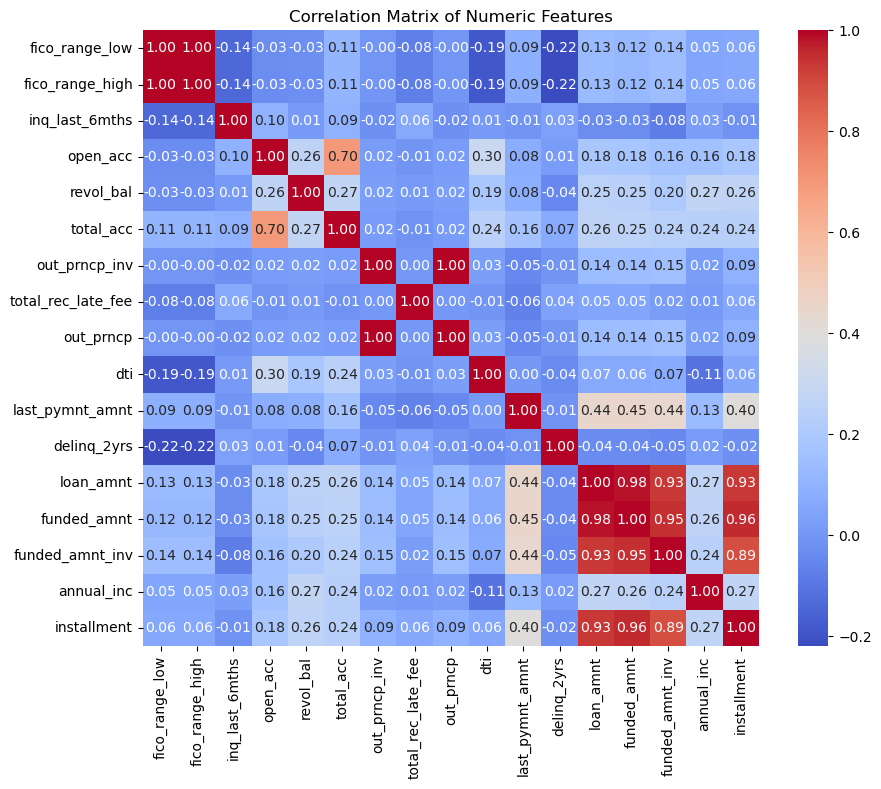

In [128]:
# Compute the correlation matrix
corr = loan[numeric_features].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### Preprocess Cat./Num Columns

In [129]:
feature_names = categorical_features + numeric_features
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Loan status to binary [0,1]

In [130]:
# Define the target variable
y = loan['loan_status'].map({'current': 0, 'default': 1})  # Convert to binary
X = loan.drop('loan_status', axis=1)

### Train, Test, Split

In [131]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)

## Baseline Model - Logistic Reg:

#### LogReg Pipeline/Train

In [132]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0, max_iter=300))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 LogisticRegression(max_iter=300, random_state=0))])

#### Model Predictions and Performance Metrics

In [133]:
y_train_pred = lr_pipeline.predict(X_train)
y_train_prob = lr_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = lr_pipeline.predict(X_test)
y_test_prob = lr_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 0.97
Precision (default): 0.96
Recall (default): 0.86
F1 Score (default): 0.91
AUC: 0.99

Test Metrics:
Accuracy: 0.91
Precision (default): 0.81
Recall (default): 0.55
F1 Score (default): 0.66
AUC: 0.94


### ROC & PR Curves

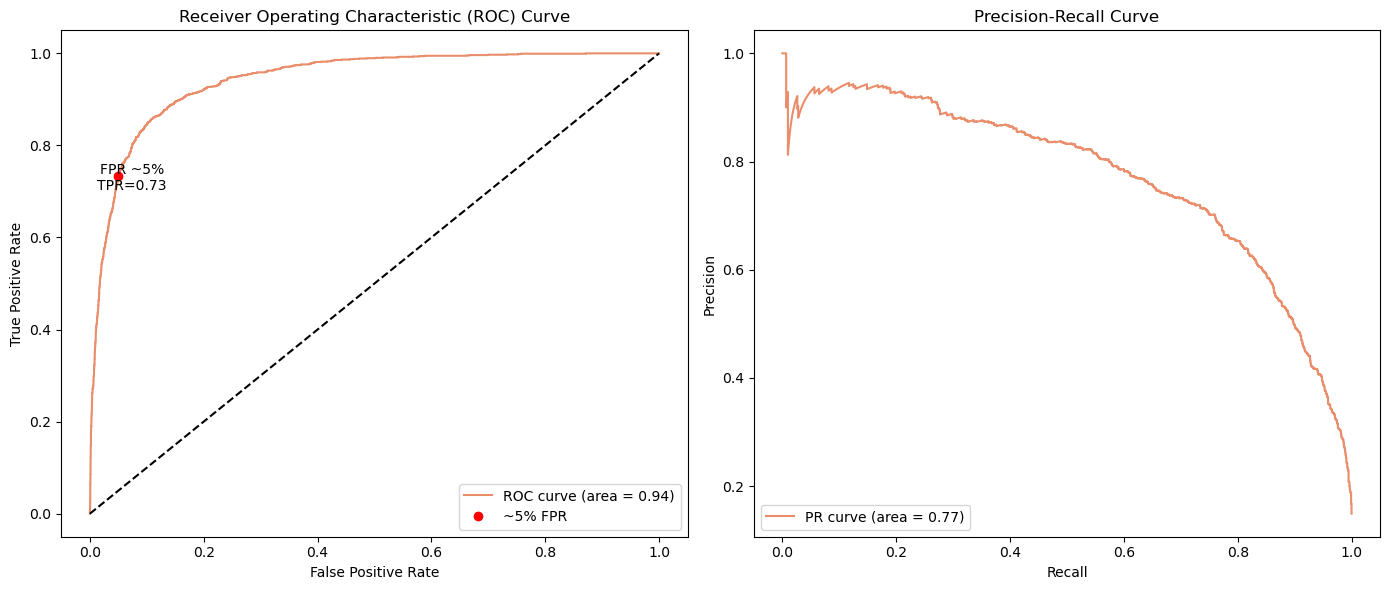

In [134]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### ROC W/ Score Threshold

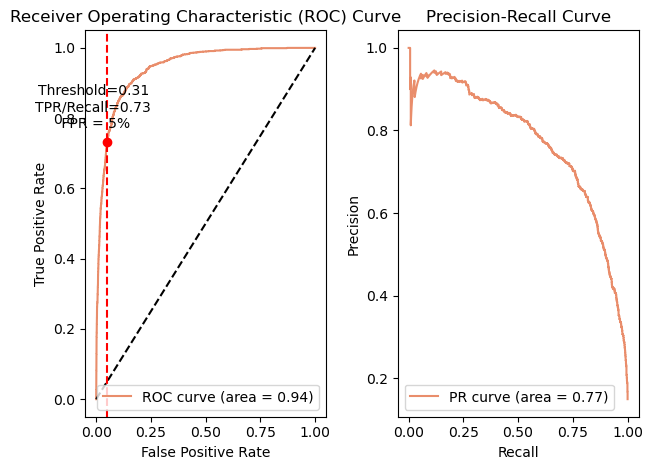

In [135]:
# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### PR Curve w/ Threshold

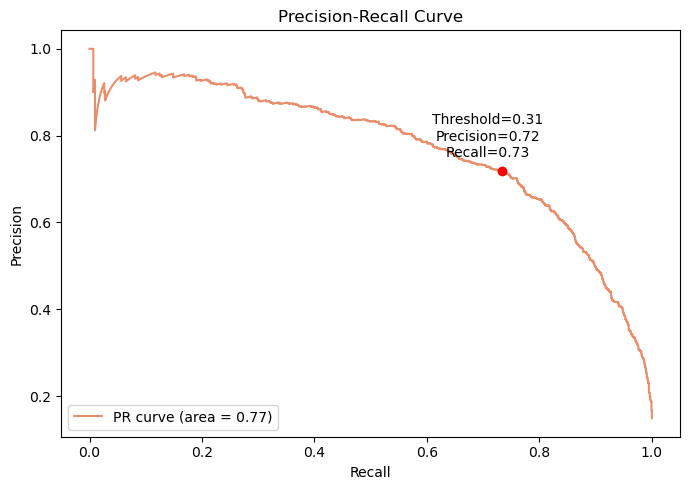

In [136]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Operating Table

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

Target FPR: 0.01, Expected TPR: 0.3761, Threshold: 0.7273
Target FPR: 0.02, Expected TPR: 0.5285, Threshold: 0.5299
Target FPR: 0.03, Expected TPR: 0.6074, Threshold: 0.4405
Target FPR: 0.04, Expected TPR: 0.6637, Threshold: 0.3755
Target FPR: 0.05, Expected TPR: 0.7327, Threshold: 0.3132
Target FPR: 0.06, Expected TPR: 0.7628, Threshold: 0.2790
Target FPR: 0.07, Expected TPR: 0.7838, Threshold: 0.2509
Target FPR: 0.08, Expected TPR: 0.8108, Threshold: 0.2287
Target FPR: 0.09, Expected TPR: 0.8303, Threshold: 0.2054
Target FPR: 0.10, Expected TPR: 0.8453, Threshold: 0.1901


,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.37613,0.72726
1,2.00000,0.52853,0.52987
2,3.00000,0.60736,0.44053
3,4.00000,0.66366,0.37547
4,5.00000,0.73273,0.31317
5,6.00000,0.76276,0.27899
6,7.00000,0.78378,0.25089
7,8.00000,0.81081,0.22869
8,9.00000,0.83033,0.20542
9,10.00000,0.84535,0.19009


## Model 1 - RandomForest:

#### Baseline RF:


##### Train Baseline Model

In [138]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=500,
                                                                    max_depth=100,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                  ['pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=100, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

##### Baseline Performance Metrics

In [139]:
y_train_pred = rf_pipeline.predict(X_train)
y_train_prob = rf_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = rf_pipeline.predict(X_test)
y_test_prob = rf_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 0.95
Precision (default): 1.00
Recall (default): 0.68
F1 Score (default): 0.81
AUC: 1.00

Test Metrics:
Accuracy: 0.85
Precision (default): 0.00
Recall (default): 0.00
F1 Score (default): 0.00
AUC: 0.87


### Optimized Random Forest:

##### Finding best parameters

###### Un-comment to run tuning

In [140]:
# Create the parameter grid
#param_grid = {
#    'classifier__n_estimators': [100, 150, 200, 250],
#    'classifier__max_depth': [None, 5, 10, 15],
#    'classifier__min_samples_split': [1,3, 5, 10],
#    'classifier__min_samples_leaf': [1, 2, 4]
#}

# Instantiate the GridSearchCV object
#grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
#best_params = grid_search.best_params_

# Print the best set of hyperparameters
#print("Best parameters:")
#for key, value in best_params.items():
#    print(f"  {key}: {value}")

##### Results of CV

In [141]:
#cv_results_df = pd.DataFrame(grid_search.cv_results_)
#cv_results_df

##### Best Parameters

In [142]:
#best_params

##### Refit with Best Parameters

In [143]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=250,
                                                                    max_depth=100,
                                                                    n_jobs=-1,
                                                                    min_samples_split=5,
                                                                    random_state=42))])
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=100, min_samples_split=5,
                                        n_estimators=250, n_jobs=-1,
                                        random_state=42))])

##### Optimized Model Performance Metrics

In [144]:
y_train_pred = rf_pipeline_hpo.predict(X_train)
y_train_prob = rf_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = rf_pipeline_hpo.predict(X_test)
y_test_prob = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 0.92
Precision (default): 1.00
Recall (default): 0.44
F1 Score (default): 0.61
AUC: 1.00

Test Metrics:
Accuracy: 0.85
Precision (default): 0.00
Recall (default): 0.00
F1 Score (default): 0.00
AUC: 0.86


### ROC & PR Curves

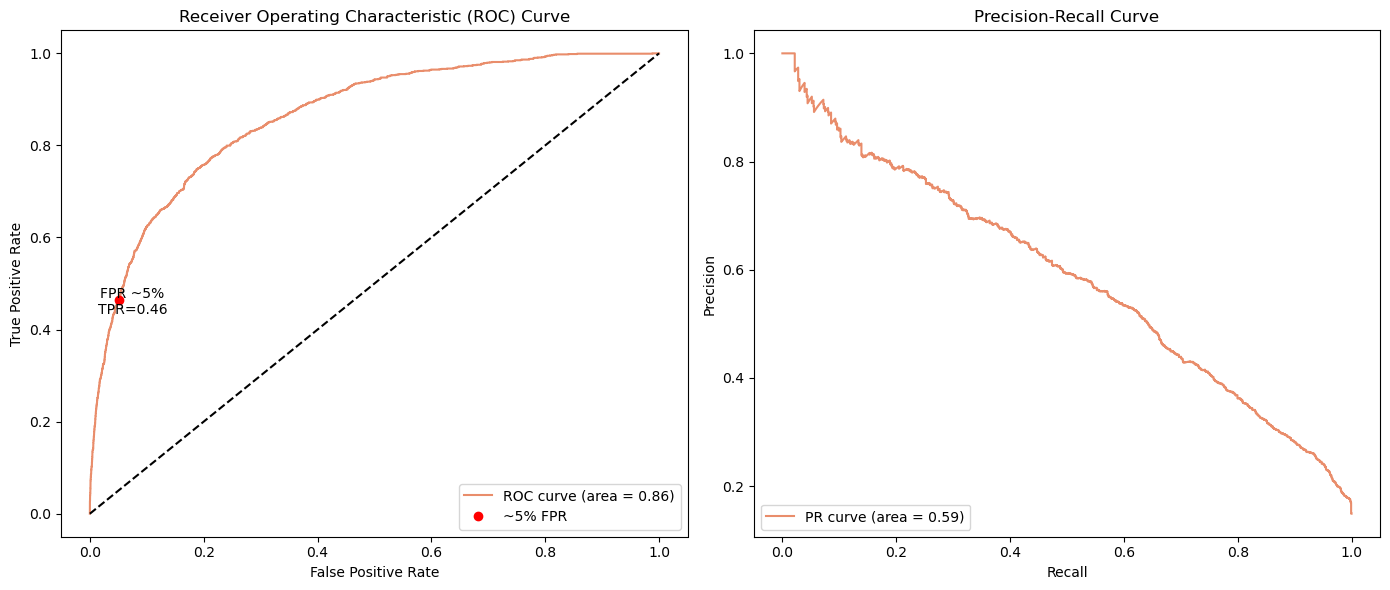

In [145]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### ROC w/ Score Threshold

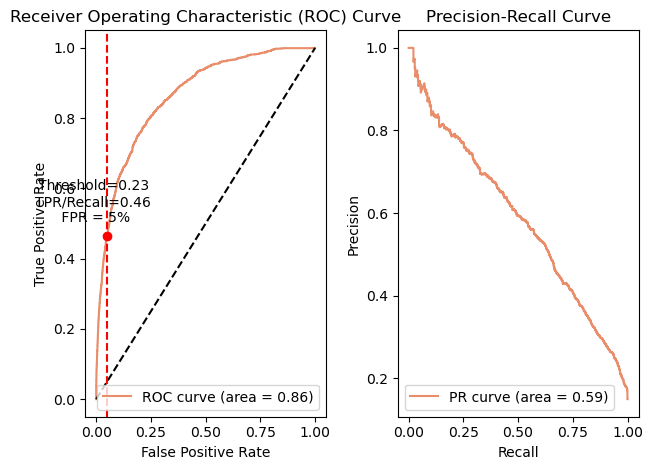

In [146]:
# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### PR Curve w/ Threshold

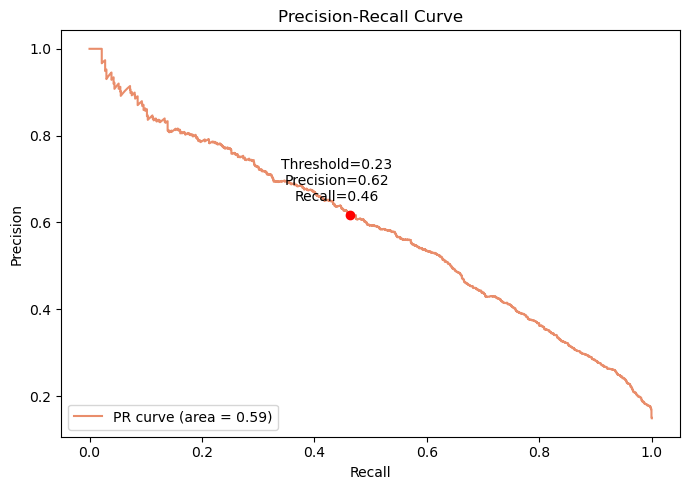

In [147]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Operating Table:

In [148]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

Target FPR: 0.01, Expected TPR: 0.2125, Threshold: 0.3013
Target FPR: 0.02, Expected TPR: 0.3011, Threshold: 0.2722
Target FPR: 0.03, Expected TPR: 0.3709, Threshold: 0.2539
Target FPR: 0.04, Expected TPR: 0.4257, Threshold: 0.2401
Target FPR: 0.05, Expected TPR: 0.4640, Threshold: 0.2309
Target FPR: 0.06, Expected TPR: 0.4985, Threshold: 0.2221
Target FPR: 0.07, Expected TPR: 0.5435, Threshold: 0.2133
Target FPR: 0.08, Expected TPR: 0.5713, Threshold: 0.2051
Target FPR: 0.09, Expected TPR: 0.5968, Threshold: 0.1977
Target FPR: 0.10, Expected TPR: 0.6231, Threshold: 0.1907


,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.21246,0.30129
1,2.00000,0.30105,0.27221
2,3.00000,0.37087,0.25391
3,4.00000,0.42568,0.24013
4,5.00000,0.46396,0.23091
5,6.00000,0.49850,0.22215
6,7.00000,0.54354,0.21325
7,8.00000,0.57132,0.20509
8,9.00000,0.59685,0.19767
9,10.00000,0.62312,0.19072


## Model 2 - (GBM):

#### Baseline GBM:

##### Train Baseline Model

In [149]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.2, 
                                                                        n_estimators=200,
                                                                        max_depth=10,
                                                                        min_samples_split=2,                         
                                                                        min_samples_leaf=3
                                                                    ))])
# Train the pipeline
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=10,
                                            min_samples_leaf=3,
                                            n_estimators=200))])

##### Baseline Performance Measure

In [150]:
y_train_pred = gbm_pipeline.predict(X_train)
y_train_prob = gbm_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = gbm_pipeline.predict(X_test)
y_test_prob = gbm_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 1.00
F1 Score (default): 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.95
Precision (default): 0.90
Recall (default): 0.73
F1 Score (default): 0.81
AUC: 0.98


#### Optimized GBM:

##### Find best parameters

###### Uncomment to run gridsearch

In [151]:
# Create the parameter grid
#param_grid = {
#    'classifier__n_estimators': [150,200,250],
#    'classifier__learning_rate': [0.1,.15, 0.2],
#}

# More in-debth parameters
#param_grid = {
#    'classifier__n_estimators': [100,150,200,250],
#    'classifier__learning_rate': [0.05, 0.1,.15, 0.2],
#    'classifier__max_depth': [None, 1, 2, 3, 5, 10],
#    'classifier__min_samples_split': [0.1, 1.0, 10],
#    'classifier__min_samples_leaf': [0.1, 0.5, 1.0, 5]
#}


# Instantiate the GridSearchCV object
#grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
#best_params = grid_search.best_params_

# Print the best set of hyperparameters
#print("Best parameters:")
#for key, value in best_params.items():
#    print(f"  {key}: {value}")

##### Result of CV

In [152]:
#cv_results_df = pd.DataFrame(grid_search.cv_results_)
#cv_results_df.head()

##### Best parameters

In [153]:
#best_params

##### Refit Model w/ new Parameters

In [154]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.1, 
                                                                        n_estimators=250,
                                                                        max_depth=10,
                                                                        min_samples_split=2,                         
                                                                        min_samples_leaf=3
                                                                    ))])
# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                  ['pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=10, min_samples_leaf=3,
                                            n_estimators=250))])

##### Optimized Model Performance Metrics

In [155]:
y_train_pred = gbm_pipeline_hpo.predict(X_train)
y_train_prob = gbm_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = gbm_pipeline_hpo.predict(X_test)
y_test_prob = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 0.97
F1 Score (default): 0.98
AUC: 1.00

Test Metrics:
Accuracy: 0.95
Precision (default): 0.90
Recall (default): 0.72
F1 Score (default): 0.80
AUC: 0.98


### ROC & PR Curves

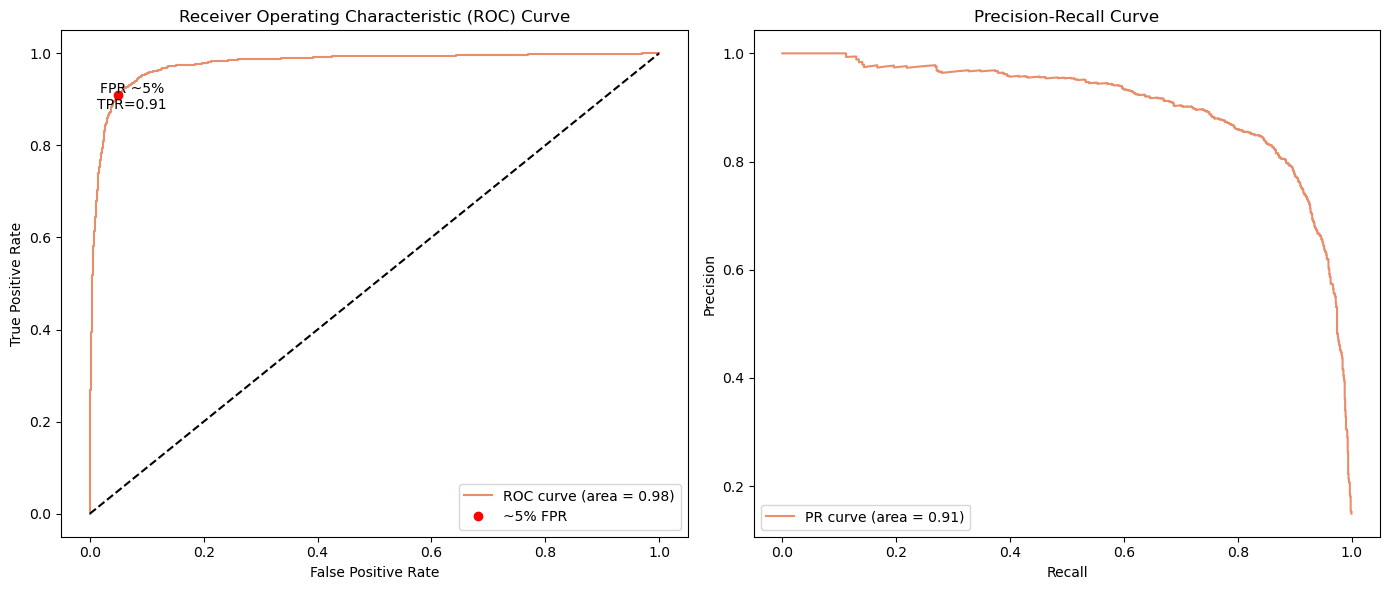

In [156]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### ROC w/ Score Threshold

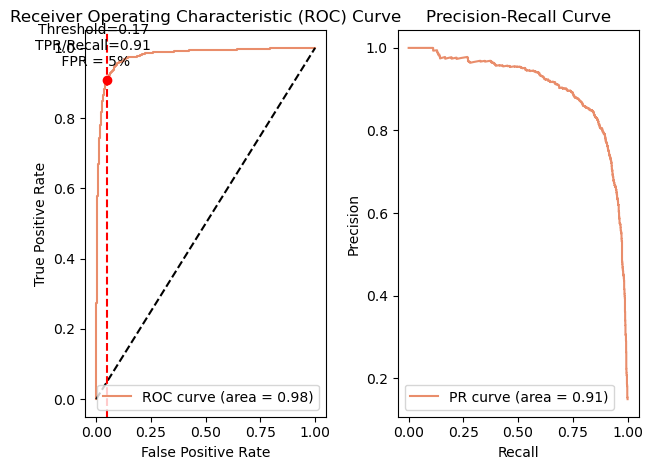

In [157]:
# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### PR Curve w/ Threshold

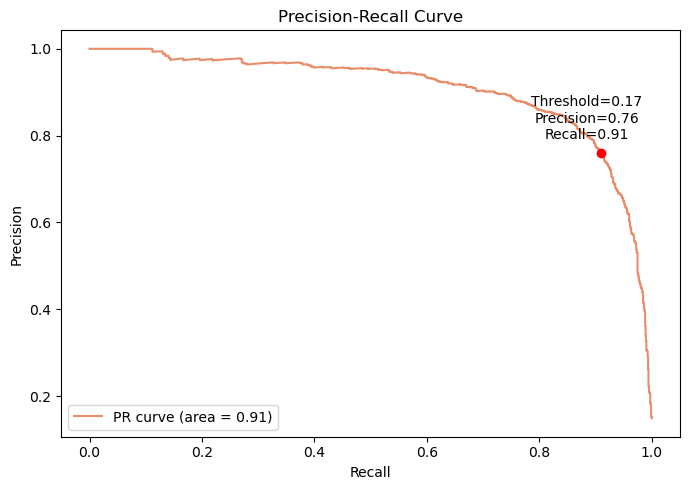

In [158]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Operating Table:

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

Target FPR: 0.01, Expected TPR: 0.6449, Threshold: 0.6058
Target FPR: 0.02, Expected TPR: 0.7815, Threshold: 0.3864
Target FPR: 0.03, Expected TPR: 0.8529, Threshold: 0.2622
Target FPR: 0.04, Expected TPR: 0.8896, Threshold: 0.2100
Target FPR: 0.05, Expected TPR: 0.9092, Threshold: 0.1708
Target FPR: 0.06, Expected TPR: 0.9234, Threshold: 0.1443
Target FPR: 0.07, Expected TPR: 0.9309, Threshold: 0.1302
Target FPR: 0.08, Expected TPR: 0.9392, Threshold: 0.1189
Target FPR: 0.09, Expected TPR: 0.9505, Threshold: 0.1069
Target FPR: 0.10, Expected TPR: 0.9565, Threshold: 0.0989


,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.64489,0.60576
1,2.00000,0.78153,0.38641
2,3.00000,0.85285,0.26215
3,4.00000,0.88964,0.20999
4,5.00000,0.90916,0.17077
5,6.00000,0.92342,0.14425
6,7.00000,0.93093,0.13019
7,8.00000,0.93919,0.11895
8,9.00000,0.95045,0.10694
9,10.00000,0.95646,0.09893


## Model 3: Neural Network (MLP)

### Baseline MLP:

#### Train MLP

In [160]:
# Define the Logistic Regression pipeline
mlp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', MLPClassifier(hidden_layer_sizes=(50,10),
                                max_iter=1000,
                                alpha=1e-4,
                                solver='sgd',
                                verbose=0,
                                tol=1e-4,
                                learning_rate_init=.1,
                                random_state=42))
])

# Train the Logistic Regression model
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(50, 10),
                               learning_rate_init=0.1, max_iter=1000,
                               random_state=42, solver='sgd', verbose=0))])

#### Baseline Model Performance Metrics

In [161]:
y_train_pred = mlp_pipeline.predict(X_train)
y_train_prob = mlp_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = mlp_pipeline.predict(X_test)
y_test_prob = mlp_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 1.00
F1 Score (default): 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.91
Precision (default): 0.73
Recall (default): 0.64
F1 Score (default): 0.68
AUC: 0.94


### Optimized MLP:

##### Find best parameters

###### Un-comment to run tuning

In [162]:
#param_grid = {
#    'classifier__learning_rate_init': [0.1, 0.001, 1,5],
#    'classifier__alpha': [0.1, 0.001, 1]
#}

# Instantiate the GridSearchCV object
#grid_search = RandomizedSearchCV(mlp_pipeline, param_grid, n_iter=2, cv=3, n_jobs=-1, scoring='roc_auc', verbose=2, random_state=42)

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
#best_params = grid_search.best_params_

# Print the best set of hyperparameters
#print("Best parameters:")
#for key, value in best_params.items():
#    print(f"  {key}: {value}")

##### Result of CV

In [163]:
#cv_results_df = pd.DataFrame(grid_search.cv_results_)
#cv_results_df.head()

##### Best parameters

In [164]:
#best_params

##### Refit Model w/ new Parameters

In [165]:
# Define the pipeline
mlp_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', MLPClassifier(
                                hidden_layer_sizes=(50,10),
                                max_iter=1000,
                                alpha=1,
                                solver='sgd',
                                verbose=0,
                                tol=1e-4,
                                learning_rate_init=.001,
                                random_state=42))
])

# Train the Logistic Regression model
mlp_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                   'pub_rec_bankruptcies',
                                                   'acc_now_delinq', 'term',
                                                   'int_rate', 'last_pymnt_d',
                                                   'grade', 'sub_grade',
                                                   'zip_code', 'revol_util',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'issue_d',
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 MLPClassifier(alpha=1, hidden_layer_sizes=(50, 10),
                               max_iter=1000, random_state=42, solver='sgd',
                               verbose=0))])

#### Optimized Model Performance Metrics

In [ ]:
y_train_pred = mlp_pipeline_hpo.predict(X_train)
y_train_prob = mlp_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = mlp_pipeline_hpo.predict(X_test)
y_test_prob = mlp_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 0.99
Precision (default): 0.99
Recall (default): 0.95
F1 Score (default): 0.97
AUC: 1.00

Test Metrics:
Accuracy: 0.95
Precision (default): 0.85
Recall (default): 0.78
F1 Score (default): 0.81
AUC: 0.97


### ROC & PR Curves

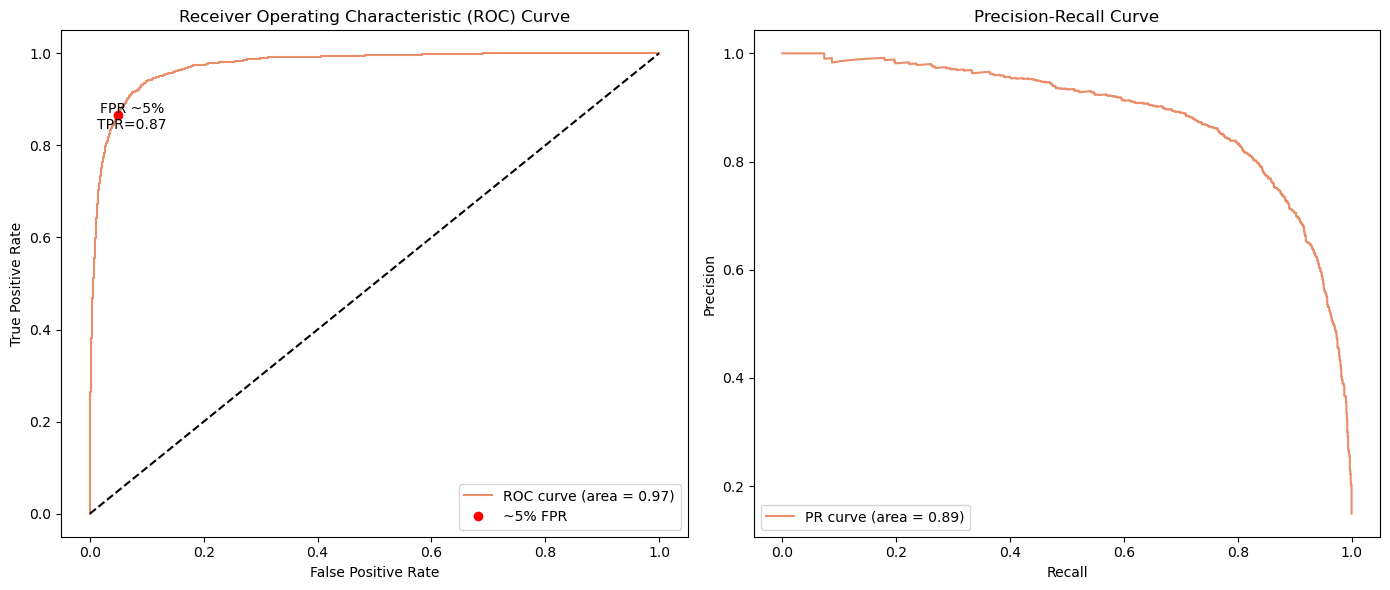

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### ROC w/ Score Threshold

In [ ]:
# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### PR Curve w/ Threshold

In [ ]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Operating Table:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

## Model 4: Stacking Classifier

### Baseline StackingClassifier:

#### Train Classifier

In [ ]:
# base estimators for stacker
base_estimators = [
    ('gbm', GradientBoostingClassifier(n_estimators=30, learning_rate=1.0, max_depth=3, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=25, random_state=42)),
    ('nn', MLPClassifier(random_state=42))
]

# final estimator on top
final_estimator = LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

# fit stacking pipeline
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                                                   'earliest_cr_line',
                                                   'purpose', 'addr_state',
                                                   'title', 'emp_title'])])),
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('gbm',
                                                 GradientBoostingClassifier(learning_rate=1.0,
                                                                            n_estimators=30,
                                                                            random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=25,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

#### Baseline Model Performence Metrics

In [ ]:
y_train_pred = stacking_pipeline.predict(X_train)
y_train_prob = stacking_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = stacking_pipeline.predict(X_test)
y_test_prob = stacking_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 0.99
Precision (default): 0.97
Recall (default): 0.98
F1 Score (default): 0.97
AUC: 1.00

Test Metrics:
Accuracy: 0.95
Precision (default): 0.85
Recall (default): 0.79
F1 Score (default): 0.82
AUC: 0.97


### Optimized Stacking Classifier:

##### Find best parameters

In [ ]:
#param_distributions = {
#    'classifier__gbm__n_estimators': randint (10,100,200),
#    'classifier__gbm__learning_rate': [0.01, 0.1, 0.5, 1.0],
#    'classifier__gbm__max_depth': randint(3, 10),
#    'classifier__rf__n_estimators': randint(10, 100),
#    'classifier__rf__max_depth': randint(3,10),
#    'classifier__rf__min_samples_split': randint(3,40),
#    'classifier__rf__min_samples_leaf': randint(3,10),
#    'classifier__nn__alpha': [0.0001, 0.001, 0.01, 0.1],
#}

# Create the RandomizedSearchCV object. You can adjust n_iter and cv (number of iterations and cross-validation folds).
#random_search = RandomizedSearchCV(stacking_pipeline,
#                                   param_distributions=param_distributions,
#                                   n_iter=2, cv=3, verbose=2, n_jobs=-1,
#                                   scoring='roc_auc', random_state=42)

# Fit the RandomizedSearchCV object to the data
# X_train and _train are your training data and labels, respectively

#random_search.fit(X_train, y_train)

# Best parameters to use for the classifier
#print ("Best parameters found:", random_search.best_params_)

# Use the best estimator directly to make predictions on test data X
#predictions = random_search. predict(X_test)

##### Refit Model w/ new Parameters

In [ ]:
# base estimators for stacker
base_estimators = [
    ('gbm', GradientBoostingClassifier(n_estimators=224, learning_rate=0.5, max_depth=6, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=96, random_state=42, min_samples_leaf=7, min_samples_split=21)),
    ('nn', MLPClassifier(alpha=0.01, random_state=42))
]

# final estimator on top
final_estimator = LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

# fit stacking pipeline
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'revol_bal', 'total_acc',
                                                   'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'out_prncp', 'dti',
                                                   'last_pymnt_amnt',
                                                   'delinq_2yrs', 'loan_amnt',
                                                   'funded_amnt',
                                                   'fun...
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('gbm',
                                                 GradientBoostingClassifier(learning_rate=0.5,
                                                                            max_depth=6,
                                                                            n_estimators=224,
                                                                            random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(min_samples_leaf=7,
                                                                        min_samples_split=21,
                                                                        n_estimators=96,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(alpha=0.01,
                                                               random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

#### Optimized Model Performence Metrics

In [ ]:
y_train_pred = stacking_pipeline.predict(X_train)
y_train_prob = stacking_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = stacking_pipeline.predict(X_test)
y_test_prob = stacking_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 1.00
F1 Score (default): 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.96
Precision (default): 0.88
Recall (default): 0.82
F1 Score (default): 0.85
AUC: 0.97


### ROC & PR Curves

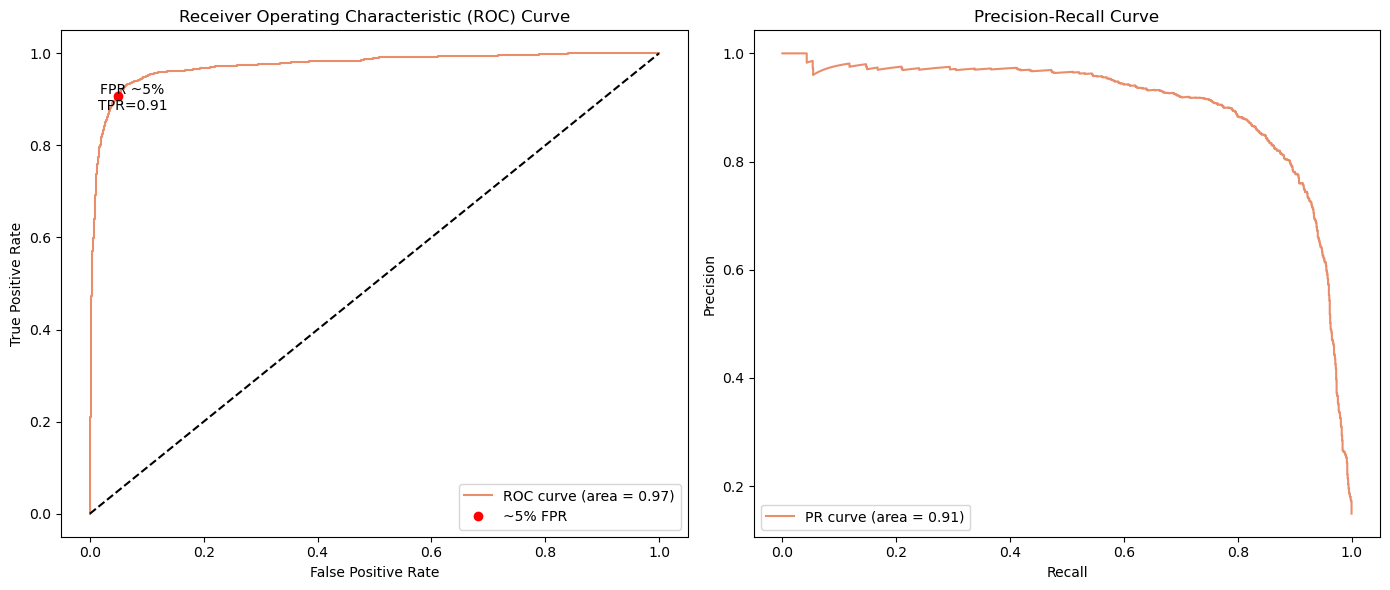

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### ROC w/ Score Threshold

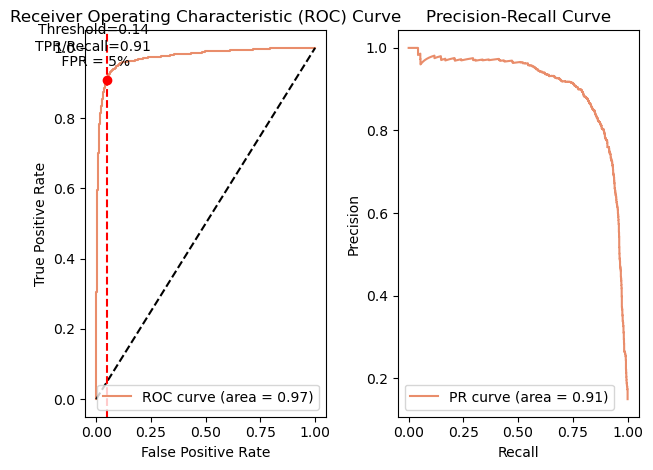

In [ ]:
# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### PR Curve w/ Threshold

In [ ]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Operating Table:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

Target FPR: 0.01, Expected TPR: 0.6922, Threshold: 0.7784
Target FPR: 0.02, Expected TPR: 0.8161, Threshold: 0.5083
Target FPR: 0.03, Expected TPR: 0.8589, Threshold: 0.3285
Target FPR: 0.04, Expected TPR: 0.8934, Threshold: 0.2038
Target FPR: 0.05, Expected TPR: 0.9077, Threshold: 0.1430
Target FPR: 0.06, Expected TPR: 0.9257, Threshold: 0.0926
Target FPR: 0.07, Expected TPR: 0.9339, Threshold: 0.0696
Target FPR: 0.08, Expected TPR: 0.9399, Threshold: 0.0549
Target FPR: 0.09, Expected TPR: 0.9444, Threshold: 0.0457
Target FPR: 0.10, Expected TPR: 0.9505, Threshold: 0.0389


,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.69219,0.77839
1,2.00000,0.81607,0.50829
2,3.00000,0.85886,0.32851
3,4.00000,0.89339,0.20382
4,5.00000,0.90766,0.14297
5,6.00000,0.92568,0.09261
6,7.00000,0.93393,0.06958
7,8.00000,0.93994,0.05489
8,9.00000,0.94444,0.04567
9,10.00000,0.95045,0.03894


## Feature Importance: All models

#### Logistic Regression Feature Importance:

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

,Feature,Coefficient
138,cat__last_credit_pull_d_Sep-2016,4.05619
587,cat__last_pymnt_d_Mar-2010,2.86568
611,cat__last_pymnt_d_Oct-2008,2.81179
577,cat__last_pymnt_d_Jun-2009,2.70909
524,cat__last_pymnt_d_Apr-2009,2.39665
620,cat__last_pymnt_d_Sep-2009,2.38943
542,cat__last_pymnt_d_Dec-2009,2.37617
595,cat__last_pymnt_d_May-2009,2.34656
535,cat__last_pymnt_d_Aug-2011,2.31547
560,cat__last_pymnt_d_Jan-2010,2.28625


#### Random Forest Feature Importance:

In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

rf_importances = rf_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)

,Feature,Importance
138,last_credit_pull_d_Sep-2016,0.09728
10,last_pymnt_amnt,0.06872
7,total_rec_late_fee,0.01867
15,annual_inc,0.01149
1,fico_range_high,0.01079
14,funded_amnt_inv,0.01077
0,fico_range_low,0.01001
16,installment,0.00922
28,term_36 months,0.00895
12,loan_amnt,0.00890


#### GBM Feature Importance:

In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

gbm_hpo_importances = gbm_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
gbm_hpo_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbm_hpo_importances})
gbm_hpo_importance_df = gbm_hpo_importance_df.sort_values(by='Importance', ascending=False)
gbm_hpo_importance_df.head(10)

,Feature,Importance
138,last_credit_pull_d_Sep-2016,0.28255
10,last_pymnt_amnt,0.23142
7,total_rec_late_fee,0.04199
627,last_pymnt_d_Sep-2016,0.03569
29,term_60 months,0.03231
16,installment,0.02730
28,term_36 months,0.02507
15,annual_inc,0.01874
14,funded_amnt_inv,0.01699
547,last_pymnt_d_Dec-2014,0.00970


#### Stacking Feature Importance (Permutations):

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(stacking_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

##### Feature Names

In [ ]:

def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Loop through each transformer within the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer, if present
            continue
        if isinstance(transformer, Pipeline):
            # If the transformer is a pipeline, get the last transformer from the pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has 'get_feature_names_out', use it
            names = list(transformer.get_feature_names_out(columns))
        else:
            # Otherwise, just use the column names directly
            names = list(columns)

        feature_names.extend(names)

    return feature_names

transformed_feature_names = get_feature_names(preprocessor)
transformed_feature_names

['fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'revol_bal',
 'total_acc',
 'out_prncp_inv',
 'total_rec_late_fee',
 'out_prncp',
 'dti',
 'last_pymnt_amnt',
 'delinq_2yrs',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'annual_inc',
 'installment',
 'pub_rec_0.0',
 'pub_rec_1.0',
 'pub_rec_2.0',
 'pub_rec_3.0',
 'pub_rec_4.0',
 'pub_rec_5.0',
 'pub_rec_bankruptcies_0.0',
 'pub_rec_bankruptcies_1.0',
 'pub_rec_bankruptcies_2.0',
 'acc_now_delinq_0.0',
 'acc_now_delinq_1.0',
 'term_36 months',
 'term_60 months',
 'last_credit_pull_d_Apr-2009',
 'last_credit_pull_d_Apr-2010',
 'last_credit_pull_d_Apr-2011',
 'last_credit_pull_d_Apr-2012',
 'last_credit_pull_d_Apr-2013',
 'last_credit_pull_d_Apr-2014',
 'last_credit_pull_d_Apr-2015',
 'last_credit_pull_d_Apr-2016',
 'last_credit_pull_d_Aug-2007',
 'last_credit_pull_d_Aug-2008',
 'last_credit_pull_d_Aug-2009',
 'last_credit_pull_d_Aug-2010',
 'last_credit_pull_d_Aug-2011',
 'last_credit_pull_d_Aug-2012',
 'last

##### Mean Importance

In [ ]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")


Feature verification_status Mean Importance: 0.086 +/- 0.002
Feature revol_bal Mean Importance: 0.077 +/- 0.002
Feature out_prncp_inv Mean Importance: 0.070 +/- 0.002
Feature open_acc Mean Importance: 0.024 +/- 0.001
Feature funded_amnt_inv Mean Importance: 0.014 +/- 0.001
Feature revol_util Mean Importance: 0.012 +/- 0.001
Feature purpose Mean Importance: 0.005 +/- 0.001
Feature emp_title Mean Importance: 0.005 +/- 0.001
Feature title Mean Importance: 0.004 +/- 0.001
Feature installment Mean Importance: 0.002 +/- 0.001
Feature addr_state Mean Importance: 0.002 +/- 0.000


##### Feature Importance

In [ ]:

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

,Feature,Importance Mean,Importance Std
0,verification_status,0.08615,0.00185
1,revol_bal,0.07696,0.00249
2,out_prncp_inv,0.07015,0.00212
3,open_acc,0.02399,0.00124
4,funded_amnt_inv,0.01406,0.00121
5,revol_util,0.01160,0.00089
6,purpose,0.00529,0.00068
7,emp_title,0.00468,0.00062
8,title,0.00385,0.00089
9,installment,0.00185,0.00062


### Graph of Feature Importance

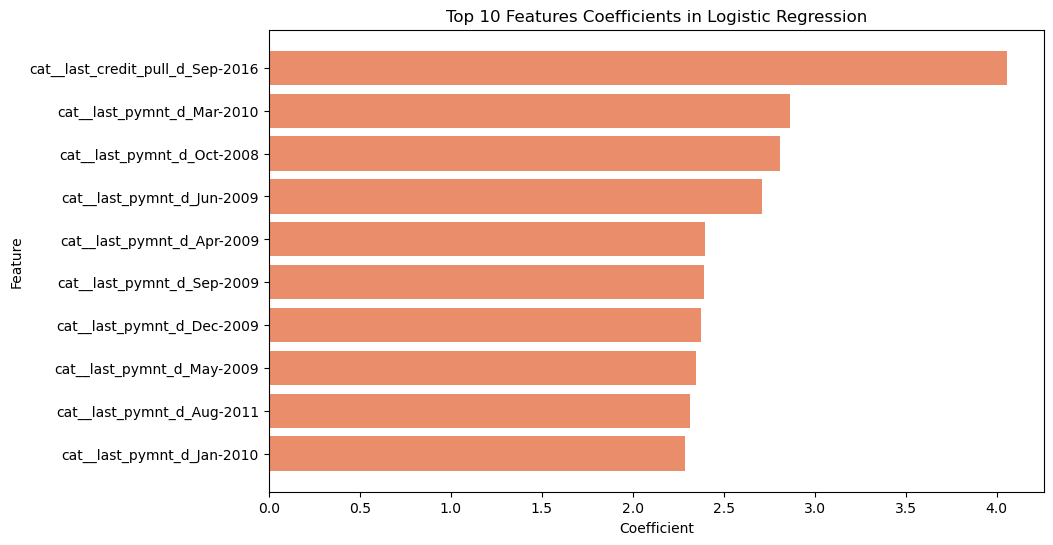

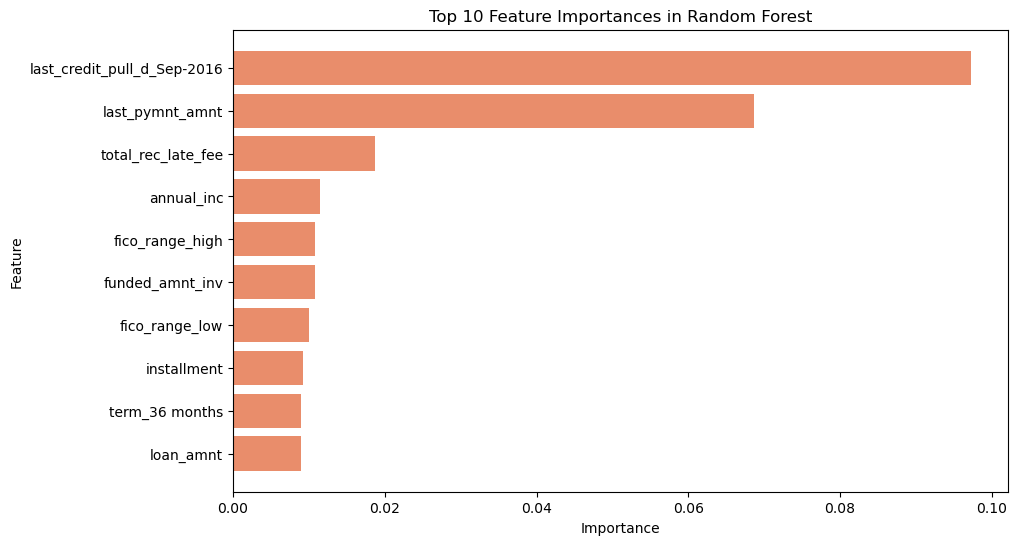

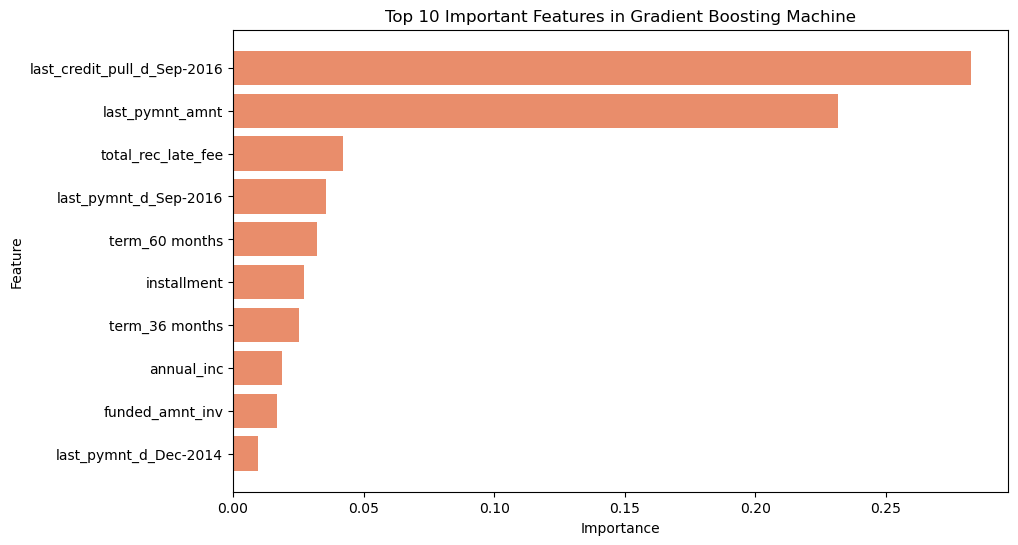

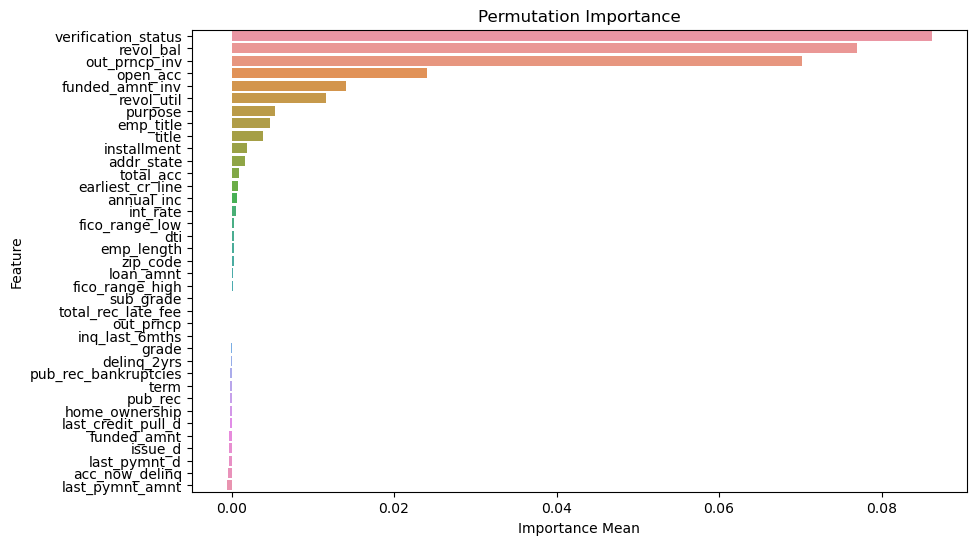

In [ ]:
# Plot for Logistic Regression
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Coefficients in Logistic Regression')
plt.barh(lr_feature_importance_df['Feature'][:10], lr_feature_importance_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Random Forest')
plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for GBM HPO Features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features in Gradient Boosting Machine")
plt.barh(gbm_hpo_importance_df['Feature'][:10], gbm_hpo_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for stacking classifier importance
plt.figure(figsize=(10, 6))
plt.title("Most Important Features in Stacking Classifier")
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Permutation Importance')
plt.show()

## Final Model: Optimized Stacking Classifier

### Partial Dependence Plots: Numerical

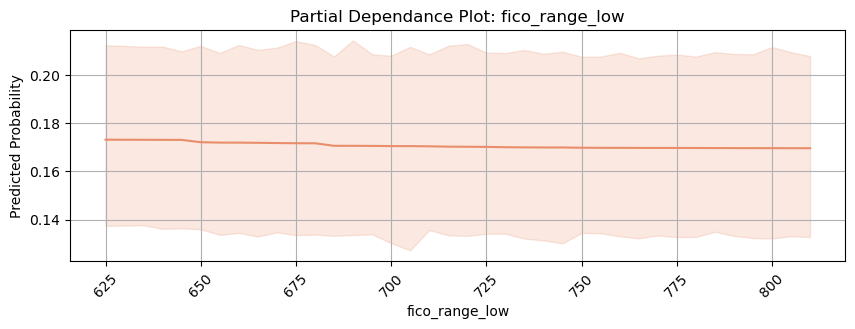

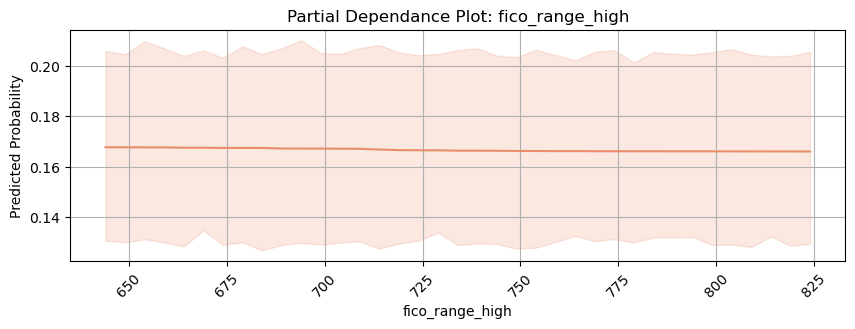

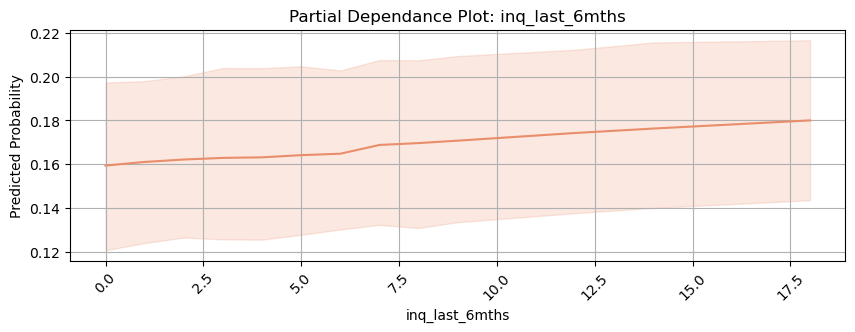

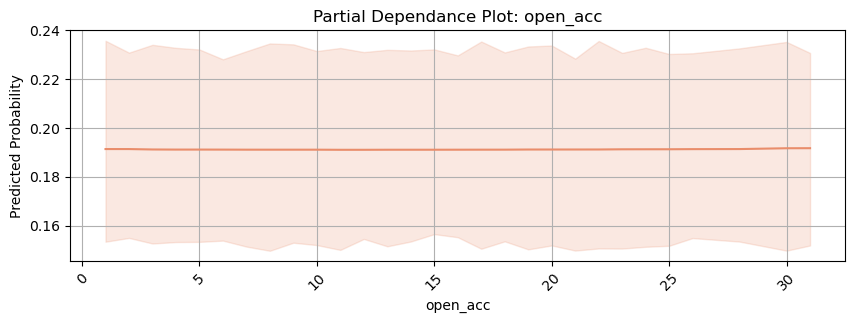

KeyboardInterrupt: 

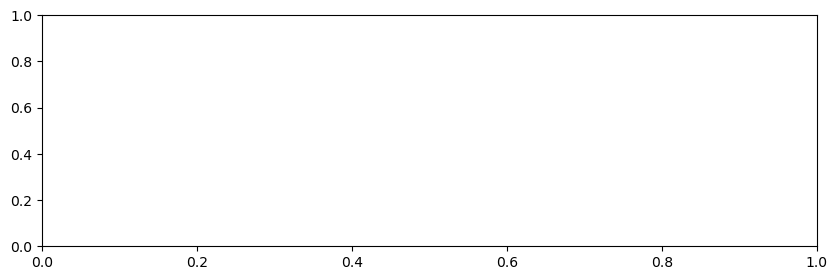

In [ ]:
def pdp_plot_numeric(var, sample_n):
  # var = 'credit_amount'
  pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.1).unique(),columns=[var])
  pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = stacking_pipeline.predict_proba(pdp_cross)[:,1]
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

# numeric_features = ['credit_amount', 'duration', 'age']
for var in numeric_features:
  pdp_plot_numeric(var, sample_n=300)

### Partial Dependence Plots: Categorical

In [ ]:
def pdp_plot_categorical(var, sample_n):
  sns.set_style("whitegrid")  # Try "darkgrid", "ticks", etc.
  sns.set_context("notebook")  # Try "paper", "notebook", "poster" for different sizes

  pdp_values = pd.DataFrame(X_test[var].sort_values().unique(),columns=[var])
  pdp_sample = X_test.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = stacking_pipeline.predict_proba(pdp_cross)[:,1]
  mean_pred = pdp_cross['pred'].mean()
  pdp_cross['pred'] = pdp_cross['pred'].apply(lambda x: x - mean_pred)
  plt.figure(figsize=(10, 3))
 #sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  sns.barplot(x=f"{var}", y='pred',
              ci=None,
              data=pdp_cross,
              estimator="mean")
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()


for var in categorical_features:
  pdp_plot_categorical(var, sample_n=100)

### Dalex Explianer

In [ ]:
import dalex as dx # for explanations
pipeline_explainer = dx.Explainer(stacking_pipeline, X_test, y_test)
pipeline_explainer

In [ ]:
model_performance  = pipeline_explainer.model_performance("classification")
model_performance.result

### Variable Importance

In [ ]:
# Calculate feature importance
fi = pipeline_explainer.model_parts(processes=4)

# Plot feature importance
fi.plot()

In [ ]:
# Let's say you want to create PDPs for a feature named 'feature_name'
pdp_numeric_profile = pipeline_explainer.model_profile(variables=numeric_features)

# Now, plot the PDP for 'feature_name'
pdp_numeric_profile.plot()

In [ ]:
pdp_categorical_profile = pipeline_explainer.model_profile(
    variable_type = 'categorical',
    variables=categorical_features)

# Now, plot the PDP for 'feature_name'
pdp_categorical_profile.plot()

In [ ]:
target = 'loan_status'

X_test['pred']= stacking_pipeline.predict(X_test)
X_test['pred_proba']= stacking_pipeline.predict_proba(X_test)[:,1]
X_test[target] = y_test
X_test.head()

,pub_rec,pub_rec_bankruptcies,acc_now_delinq,term,last_credit_pull_d,int_rate,last_pymnt_d,grade,sub_grade,zip_code,...,last_pymnt_amnt,delinq_2yrs,loan_amnt,funded_amnt,funded_amnt_inv,annual_inc,installment,pred,pred_proba,loan_status
28052,1.00000,1.00000,0.00000,36 months,Sep-2016,7.88%,Sep-2013,A,A5,431xx,...,138.29000,0.00000,4200.00000,4200.00000,4100.00000,73500.00000,131.39000,0,0.05442,0
4137,0.00000,0.00000,0.00000,60 months,Oct-2015,13.49%,Apr-2015,C,C1,786xx,...,7183.11000,0.00000,18000.00000,18000.00000,17975.00000,60000.00000,414.09000,0,0.01758,0
18106,1.00000,1.00000,0.00000,36 months,Sep-2013,15.95%,Sep-2013,D,D4,984xx,...,254.71000,0.00000,7000.00000,7000.00000,7000.00000,61392.00000,245.93000,0,0.02249,0
6975,0.00000,0.00000,0.00000,36 months,Dec-2012,10.99%,Dec-2012,B,B3,928xx,...,15729.78000,0.00000,25000.00000,25000.00000,25000.00000,57120.00000,818.35000,0,0.01561,0
21946,0.00000,0.00000,0.00000,36 months,May-2016,13.48%,Apr-2013,C,C3,853xx,...,76.72000,0.00000,2000.00000,2000.00000,1975.00000,20928.00000,67.85000,0,0.01870,0


### Top 10 True Positives:

In [ ]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

,pub_rec,pub_rec_bankruptcies,acc_now_delinq,term,last_credit_pull_d,int_rate,last_pymnt_d,grade,sub_grade,zip_code,...,last_pymnt_amnt,delinq_2yrs,loan_amnt,funded_amnt,funded_amnt_inv,annual_inc,installment,pred,pred_proba,loan_status
0,0.00000,0.00000,0.00000,36 months,Sep-2016,17.03%,Apr-2009,F,F5,900xx,...,127.03000,0.00000,3500.00000,3500.00000,0.00000,70000.00000,124.84000,1,0.98352,1
1,0.00000,0.00000,0.00000,60 months,Sep-2016,21.74%,Apr-2013,F,F5,935xx,...,34.23000,0.00000,25000.00000,25000.00000,24778.19492,80000.00000,686.79000,1,0.98295,1
2,0.00000,NaN,0.00000,36 months,Sep-2016,16.08%,Oct-2008,F,F2,956xx,...,246.38000,0.00000,7000.00000,7000.00000,0.00749,189500.00000,246.38000,1,0.98276,1
3,0.00000,0.00000,0.00000,60 months,Sep-2016,20.89%,May-2015,F,F1,890xx,...,350.00000,1.00000,35000.00000,35000.00000,34819.47828,120000.00000,944.71000,1,0.98261,1
4,0.00000,0.00000,0.00000,36 months,Sep-2016,13.24%,Jun-2009,D,D3,503xx,...,497.01000,0.00000,14700.00000,14700.00000,9624.99800,24000.00000,497.01000,1,0.98250,1
5,0.00000,0.00000,0.00000,60 months,Sep-2016,17.19%,Oct-2011,E,E3,921xx,...,160.95000,0.00000,12000.00000,12000.00000,10700.00000,60000.00000,299.46000,1,0.98241,1
6,0.00000,NaN,0.00000,36 months,Sep-2016,15.33%,Oct-2009,F,F2,655xx,...,383.10000,0.00000,11000.00000,11000.00000,1199.99885,30000.00000,383.10000,1,0.98231,1
7,0.00000,0.00000,0.00000,60 months,Sep-2016,21.74%,May-2012,F,F5,331xx,...,34.60000,0.00000,25000.00000,25000.00000,24950.00000,45000.00000,686.79000,1,0.98211,1
8,0.00000,0.00000,0.00000,60 months,Sep-2016,21.67%,Dec-2012,F,F3,117xx,...,412.98000,0.00000,15000.00000,15000.00000,14975.00000,33000.00000,411.48000,1,0.98210,1
9,0.00000,0.00000,0.00000,60 months,Sep-2016,19.79%,Jan-2012,F,F5,347xx,...,343.88000,1.00000,16000.00000,16000.00000,15757.18306,80000.00000,422.04000,1,0.98205,1


### Top 10 False Positives:

### Top 10 False Negatives: